In [1]:
import json
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from src.utils.UsefulPaths import Paths
from sklearn.cluster import KMeans
from src.utils.KnnUtils import OptimalCluster
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)

2023-11-05 12:58:36,864 - DEBUG - matplotlib data path: C:\Users\Thiago\PycharmProjects\genome\venv\Lib\site-packages\matplotlib\mpl-data
2023-11-05 12:58:36,867 - DEBUG - CONFIGDIR=C:\Users\Thiago\.matplotlib
2023-11-05 12:58:36,869 - DEBUG - interactive is False
2023-11-05 12:58:36,870 - DEBUG - platform is win32
2023-11-05 12:58:36,898 - DEBUG - CACHEDIR=C:\Users\Thiago\.matplotlib
2023-11-05 12:58:36,900 - DEBUG - Using fontManager instance from C:\Users\Thiago\.matplotlib\fontlist-v330.json


In [2]:
paths = Paths()

In [3]:
df_abstract_patents = pd.read_csv(os.path.join(paths.data_processed, 'abstract_patents_sliced_15000.csv'))

In [5]:
slice_number = 15000
df_sliced = df_abstract_patents[:slice_number]
df_sliced.to_csv(os.path.join(paths.data_processed, 'abstract_patents_sliced.csv'), index=False)
df_sliced

,publication_number,abstract,word_count,app_name,app_year,city,country,country_name,ecosystem,grant_date,grant_year,app_date,class_concat,class_distinct_count,class_ipc_concat,class_ipc_distinct_count,processed_abstract,token_count
0,20180152842,"A method, and a mobile device adapted thereto,...",80,Moorim Kim,2018,Seoul,KR,"Korea, Republic of",Seoul,2018-05-31 00:00:00+00:00,2018,2018-01-29 00:00:00+00:00,"H04M,H04W,G06F",3.00,"G06F,H04M,H04W",3.00,method mobile device adapt thereto verify user...,46
1,20180140889,A dumbbell with a selectable number of weight ...,131,Per HÖGLUND,2018,Jonkoping,SE,Sweden,Jonkoping,2018-05-24 00:00:00+00:00,2018,2018-01-03 00:00:00+00:00,A63B,1.00,A63B,1.00,dumbbell selectable number weight disk include...,76
2,20180143803,A virtual assistant AI system that may be conn...,83,David Placa,2018,San Francisco,US,United States,Silicon Valley,2018-05-24 00:00:00+00:00,2018,2018-01-16 00:00:00+00:00,G06F,1.00,G06F,1.00,virtual assistant ai system connect wide varie...,49
3,20180169402,Connector assemblies that are separate from me...,101,Patrick Wells,2018,Columbia Heights,US,United States,Minneapolis,2018-06-21 00:00:00+00:00,2018,2018-02-15 00:00:00+00:00,"H01R,A61N",2.00,"A61N,H01R",2.00,connector assembly separate medical lead exten...,60
4,20180163931,"An LED tube lamp, comprising a lamp tube, whic...",130,Aiming Xiong,2018,Jiaxing,CN,China,Hangzhou,2018-06-14 00:00:00+00:00,2018,2018-02-06 00:00:00+00:00,"F21Y,F21K,F21V,H05B",4.00,"F21K,F21V,F21Y,H05B",4.00,led tube lamp comprise lamp tube include light...,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,20180341581,['An object of the present invention is to pro...,156,Eiji Koeta,2018,Tokyo,JP,Japan,Tokyo,2018-11-29 00:00:00+00:00,2018,2018-03-07 00:00:00+00:00,"G11C,H01L,G06F",3.00,"G06F,G11C,H01L",3.00,object present invention provide semiconductor...,89
14996,20180243060,An intraoral device holder is provided. In som...,91,Wesley Wilson,2018,Las Vegas,US,United States,Las Vegas,2018-08-30 00:00:00+00:00,2018,2018-04-27 00:00:00+00:00,"A45D,B65D,A61C,G08B,A63B,H02J",6.00,"A45D,A61C,A63B,B65D,G08B,H02J",6.00,intraoral device holder provide embodiment int...,43
14997,20180194544,An apparatus and method for packaging and inst...,99,Jeremy Tarr,2018,Somerville,US,United States,Boston,2018-07-12 00:00:00+00:00,2018,2018-01-09 00:00:00+00:00,"F04D,B65D",2.00,"B65D,F04D",2.00,apparatus method packaging instal ceiling fan ...,49
14998,20180210963,This patent specification describes a barcode-...,149,George Powell,2018,Draper,US,United States,Salt Lake-Provo,2018-07-26 00:00:00+00:00,2018,2018-03-19 00:00:00+00:00,"G06F,G06K,H04W",3.00,"G06F,G06K,H04W",3.00,patent specification describe barcode read sys...,91


In [6]:
embedder = SentenceTransformer('distilbert-base-uncased')

2023-11-05 12:58:44,751 - INFO - Load pretrained SentenceTransformer: distilbert-base-uncased
2023-11-05 12:58:44,753 - DEBUG - Starting new HTTPS connection (1): huggingface.co:443
2023-11-05 12:58:45,282 - DEBUG - https://huggingface.co:443 "GET /api/models/distilbert-base-uncased HTTP/1.1" 200 8027
2023-11-05 12:58:45,456 - DEBUG - https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/.gitattributes HTTP/1.1" 200 0
2023-11-05 12:58:45,620 - DEBUG - https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/LICENSE HTTP/1.1" 200 0
2023-11-05 12:58:45,785 - DEBUG - https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/README.md HTTP/1.1" 200 0
2023-11-05 12:58:45,946 - DEBUG - https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/config.json HTTP/1.1" 200 0
2023-11-05 12:58:46,111 

In [7]:
sentences = list(df_sliced.processed_abstract)

In [8]:
sentences_embeddings = embedder.encode(sentences)

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

In [9]:
sentences_embeddings_normalized = sentences_embeddings / np.linalg.norm(x=sentences_embeddings, axis=1, keepdims=True)

In [10]:
optimal_clusters = OptimalCluster(data=sentences_embeddings_normalized, n_cluster_min=5, n_cluster_max=20, random_state=42)

Optimal k for elbow method: 10
Optimal k for silhouette method: 5


2023-11-05 13:05:51,381 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-11-05 13:05:51,381 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-11-05 13:05:51,383 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.200000000000001.
2023-11-05 13:05:51,384 - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\Thiago\\PycharmProjects\\genome\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-11-05 13:05:51,384 - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\Thiago\\PycharmProjects\\genome\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-11-05 13:05:5

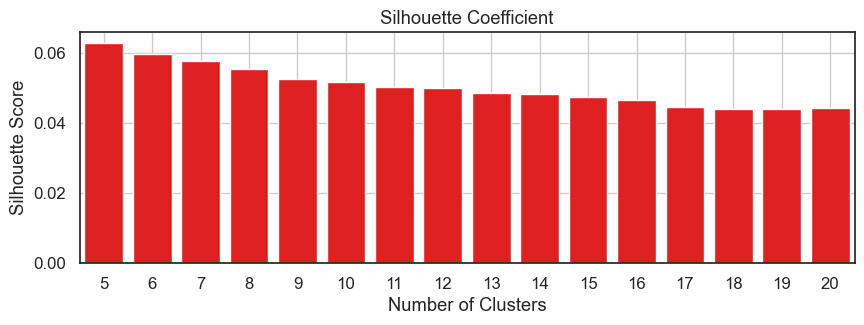

In [11]:
optimal_clusters.plot_silhouette_scores()

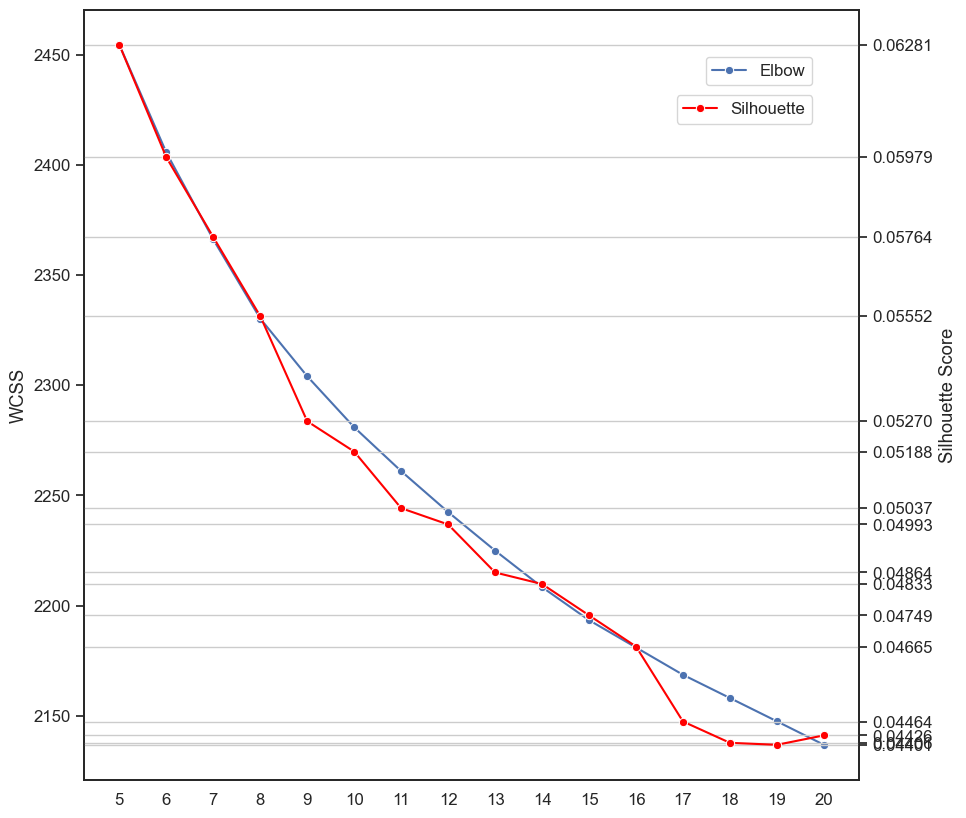

In [12]:
optimal_clusters.plot_elbow_and_silhouette_lines()

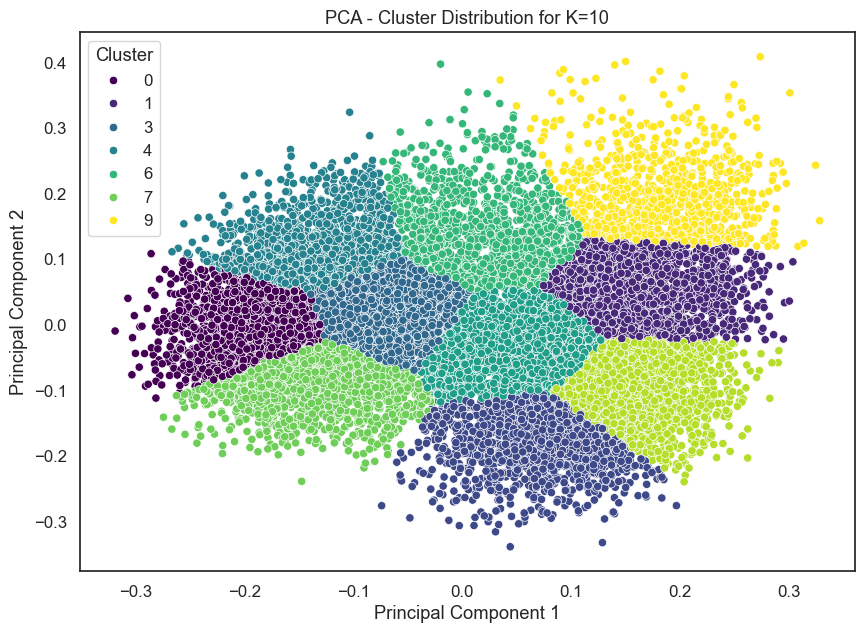

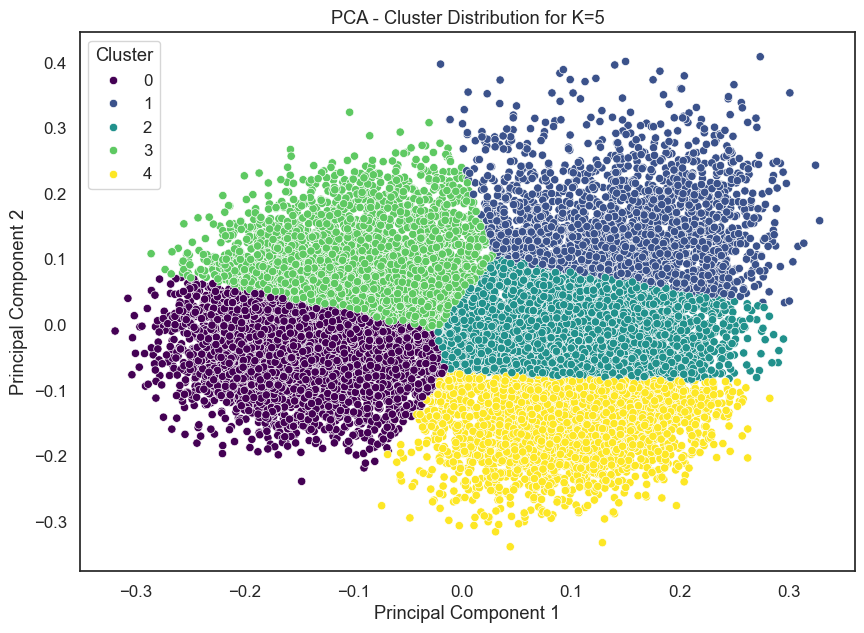

In [13]:
optimal_clusters.plot_pca_best_distributions()

In [14]:
knn_model = optimal_clusters.get_kmeans(k=18)
knn_labels = knn_model.labels_
print(knn_labels)

[10  8  3 ...  2  7 16]


In [15]:
df_new = pd.DataFrame({'abstract': sentences, 'class': knn_labels})
df_new

,abstract,class
0,method mobile device adapt thereto verify user...,10
1,dumbbell selectable number weight disk include...,8
2,virtual assistant ai system connect wide varie...,3
3,connector assembly separate medical lead exten...,14
4,led tube lamp comprise lamp tube include light...,14
...,...,...
14995,object present invention provide semiconductor...,9
14996,intraoral device holder provide embodiment int...,0
14997,apparatus method packaging instal ceiling fan ...,2
14998,patent specification describe barcode read sys...,7
